<a href="https://colab.research.google.com/github/viscory/semeval3108/blob/master/Copy_of_NN_subtask_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import csv
from tqdm import tqdm
from sklearn.utils import shuffle
import nltk
import re
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM, Reshape, Dropout, Flatten
from keras import regularizers 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#declare path
path_to_project = '/content/gdrive/My Drive/ESTR project AI/OLIDv1.0/'
path_to_data = path_to_project + 'olid-training-v1.0.tsv'

In [0]:
#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others
def get_label(labels):
  answer = 0
  if labels[1] == 'UNT':
    answer = 1
  if labels[2] == 'IND':
    answer = 2
  if labels[2] == 'GRP':
    answer = 3
  if labels[2] == 'OTH':
    answer = 4
  return answer

def convert(label, sub_task):
  if sub_task == 'a':
    return int(label > 0)
  if sub_task == 'b':
    return int(label > 1)
  return label - 2

def prepare_data(path,sub_task):
  data=[]
  labels=[]
  with open(path,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      data.append(line[1])
      labels.append(convert(get_label(line[-3:]),sub_task))
  return data,labels  

def get_test_label(label,sub_task):
  answer = 0
  if sub_task == 'a':
    if label == 'OFF':
      answer = 1
  if sub_task == 'b':
    if label == 'TIN':
      answer = 1
  if sub_task == 'c':
    if label == 'GRP':
      answer = 1
    if label == 'OTH':
      answer = 2
  return answer
def get_test_data(sub_task):
  data=[]
  labels=[]
  path_labels = path_to_project + 'labels-level' + sub_task + '.csv'
  path_data = path_to_project + 'testset-level' + sub_task + '.tsv'
  with open(path_data,encoding='utf8') as file:
    for i,line in enumerate(csv.reader(file,delimiter='\t')):
      if i == 0:
        continue
      data.append(line[1])
  with open(path_labels,encoding='utf8') as file:
    for line in csv.reader(file):
      labels.append(get_test_label(line[1],sub_task))
      #labels.append(line[1])
  return data,labels

In [0]:
#preprocessing dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#preprocessing
def tokenize(data):
  answer = []
  for text in data:
    answer.append(nltk.word_tokenize(text.lower()))
  return answer

def stop_words(data):
  answer = []
  bad_words = set(nltk.corpus.stopwords.words('english'))
  for text in data:
    answer.append([x for x in text if not x in bad_words and not re.match(r"[^a-zA-Z\d\s]+", x) and x != 'user'])
  return answer

def get_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
  return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)
  
def lemmatize(data):
  answer = []      
  lemmatizer = nltk.stem.WordNetLemmatizer()
  for text in data:
    answer.append([lemmatizer.lemmatize(x, pos=get_tag(x)) for x in text])
  return answer
  
#Vectorization
def count_vectorizer_len(data):
  vectorizer = CountVectorizer()
  converted_data = [' '.join(x) for x in data]
  vectorizer.fit(converted_data)
  return len(vectorizer.vocabulary_.keys())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
#preparing data to be compatibel with Neural networks
def do_one_hot(data):
  encoder = OneHotEncoder();
  return encoder.fit_transform(np.array(data).reshape(-1,1)).toarray()
def do_input_proc(data, len, longest_seq):
  converted_data = [keras.preprocessing.text.one_hot(' '.join(x), len) for x in data]
  return keras.preprocessing.sequence.pad_sequences(converted_data, maxlen=longest_seq, padding='post')
def get_max_len(data):
  answer = 0
  for x in data:
    answer = max(answer, len(x))
  return answer

In [0]:
def plot_confusion(data, labels, model, classes=2):
  predicted_labels = model.predict(data, batch_size=64)
  mtx = np.zeros(shape=(classes,classes))
  for i in range(0,len(predicted_labels)):
    actual_label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    mtx[actual_label,predicted_label] += 1
  norm = np.zeros(shape=(classes,classes))
  for i in range(classes):
    for j in range(classes):
      norm[i][j] = mtx[i][j] / np.sum(mtx[i])
  print(norm)
  plt.imshow(mtx,cmap=plt.cm.ocean_r)
  plt.title('Confusion matrix')
  plt.colorbar()
  marks = [x for x in ['NOT', 'OFF']]
  plt.xlabel('Predicted Label')
  plt.xticks(np.arange(classes), marks)
  plt.ylabel('True Label')
  plt.yticks(np.arange(classes), marks)
  plt.tight_layout()
  for (i, j), z in np.ndenumerate(mtx):
    plt.text(j, i, int(z), ha='center', va='center')
  plt.show()
def do_analysis(test_data, test_labels, model):
  predicted_labels = model.predict(test_data, batch_size=64)
  y_true = np.argmax(test_labels, axis = 1)
  y_pred = np.argmax(predicted_labels, axis = 1)
  print(classification_report(y_true, y_pred))
  plot_confusion(test_data, test_labels, model, 2)

In [0]:
data,labels = prepare_data(path_to_data,'a')
test_data,test_labels = get_test_data('a')
data = lemmatize(stop_words(tokenize(data)))
test_data = lemmatize(stop_words(tokenize(test_data)))
vocab_length = count_vectorizer_len(data)
longest_seq = max(get_max_len(data),get_max_len(test_data))
#convert data to work with NN
train_data, val_data, train_labels, val_labels = train_test_split(np.array(data),labels, test_size=0.35,stratify=labels)
train_labels = do_one_hot(train_labels)
val_labels = do_one_hot(val_labels)
test_labels = do_one_hot(test_labels)
train_data = do_input_proc(train_data, vocab_length, longest_seq)
val_data = do_input_proc(val_data, vocab_length, longest_seq)
test_data = do_input_proc(test_data, vocab_length, longest_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [0]:
# lstm model
lstm = Sequential()
lstm.add(Embedding(vocab_length, 30, input_length=longest_seq))
lstm.add(Dropout(0.5))
lstm.add(LSTM(100))
#lstm.add(Dense(longest_seq, activation='relu', W_regularizer=regularizers.l2(0.90))) , W_regularizer=regularizers.l2(0.1))
lstm.add(Dense(train_labels.shape[1], activation='softmax'))
madam = Adam(lr=0.008)
lstm.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm.summary()
early_stopping = EarlyStopping(monitor='val_acc', patience=5)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 44, 30)            472380    
_________________________________________________________________
dropout_5 (Dropout)          (None, 44, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 524,982
Trainable params: 524,982
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm.fit(train_data, train_labels, batch_size=64,epochs=5,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Train on 8606 samples, validate on 4634 samples
Epoch 1/5
8606/8606 [==============================] - 18s 2ms/step - loss: 0.6394 - acc: 0.6678 - val_loss: 0.6357 - val_acc: 0.6677
Epoch 2/5
8606/8606 [==============================] - 17s 2ms/step - loss: 0.6372 - acc: 0.6677 - val_loss: 0.6370 - val_acc: 0.6677
Epoch 3/5
8606/8606 [==============================] - 17s 2ms/step - loss: 0.6367 - acc: 0.6677 - val_loss: 0.6353 - val_acc: 0.6677
Epoch 4/5
8606/8606 [==============================] - 17s 2ms/step - loss: 0.5573 - acc: 0.7264 - val_loss: 0.6228 - val_acc: 0.7268
Epoch 5/5
8606/8606 [==============================] - 17s 2ms/step - loss: 0.4347 - acc: 0.8136 - val_loss: 0.5415 - val_acc: 0.7393


In [0]:
print(lstm.metrics_names, lstm.evaluate(test_data, test_labels, batch_size=64, verbose=1))

860/860 [==============================] - 1s 631us/step
['loss', 'acc'] [0.4850301146507263, 0.7709302320036777]


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       620
           1       0.59      0.60      0.59       240

    accuracy                           0.77       860
   macro avg       0.72      0.72      0.72       860
weighted avg       0.77      0.77      0.77       860

[[0.83709677 0.16290323]
 [0.4        0.6       ]]


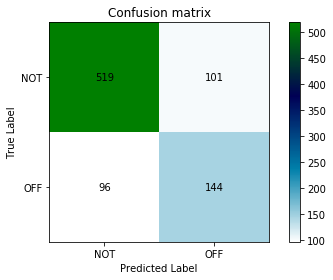

In [0]:
do_analysis(test_data, test_labels, lstm)

In [0]:
# lstm model
lstm_complex = Sequential()
lstm_complex.add(Embedding(vocab_length, 30, input_length=longest_seq))
#lstm_complex.add(Dropout(0.4))
lstm_complex.add(LSTM(50))
lstm_complex.add(Dense(longest_seq, activation='relu'))
lstm_complex.add(Dropout(0.75))
lstm_complex.add(Dense(train_labels.shape[1], activation='sigmoid'))
#madam = Adam(lr=0.008)
lstm_complex.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
lstm_complex.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 44, 30)            472380    
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                16200     
_________________________________________________________________
dense_20 (Dense)             (None, 44)                2244      
_________________________________________________________________
dropout_18 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 90        
Total params: 490,914
Trainable params: 490,914
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
lstm_complex.fit(train_data, train_labels, batch_size=64,epochs=8,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Train on 8606 samples, validate on 4634 samples
Epoch 1/8
8606/8606 [==============================] - 20s 2ms/step - loss: 0.6506 - acc: 0.6666 - val_loss: 0.6375 - val_acc: 0.6677
Epoch 2/8
8606/8606 [==============================] - 16s 2ms/step - loss: 0.6018 - acc: 0.7011 - val_loss: 0.5530 - val_acc: 0.7128
Epoch 3/8
8606/8606 [==============================] - 16s 2ms/step - loss: 0.4582 - acc: 0.8144 - val_loss: 0.5432 - val_acc: 0.7393
Epoch 4/8
8606/8606 [==============================] - 16s 2ms/step - loss: 0.3657 - acc: 0.8695 - val_loss: 0.5896 - val_acc: 0.7391
Epoch 5/8
8606/8606 [==============================] - 16s 2ms/step - loss: 0.3093 - acc: 0.8960 - val_loss: 0.5961 - val_acc: 0.7352


In [0]:
print(lstm_complex.metrics_names, lstm_complex.evaluate(test_data, test_labels, batch_size=64, verbose=1))

860/860 [==============================] - 1s 626us/step
['loss', 'acc'] [0.5510285197302353, 0.7697674426921578]


              precision    recall  f1-score   support

           0       0.82      0.87      0.85       620
           1       0.60      0.51      0.55       240

    accuracy                           0.77       860
   macro avg       0.71      0.69      0.70       860
weighted avg       0.76      0.77      0.76       860

[[0.87096774 0.12903226]
 [0.49166667 0.50833333]]


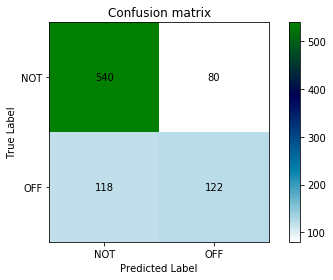

In [0]:
do_analysis(test_data, test_labels, lstm_complex)

In [0]:
cnn = Sequential()
cnn.add(Embedding(vocab_length, 30, input_length=longest_seq))
cnn.add(Reshape((30,longest_seq,1)))
cnn.add(Convolution2D(32,(1,5),activation="relu"))
cnn.add(Dropout(0.9))
cnn.add(Convolution2D(16,(2,3),activation="relu"))
cnn.add(Dropout(0.8))
cnn.add(Convolution2D(16,(2,2),activation="relu"))
cnn.add(Dropout(0.7))
cnn.add(Flatten())
cnn.add(Dense(train_labels.shape[1],activation='softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
cnn.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 44, 30)            472380    
_________________________________________________________________
reshape_1 (Reshape)          (None, 30, 44, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 40, 32)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 38, 16)        3088      
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 38, 16)        0         
____

In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
cnn.fit(train_data, train_labels, batch_size=64,epochs=60,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Train on 8606 samples, validate on 4634 samples
Epoch 1/60
8606/8606 [==============================] - 6s 672us/step - loss: 0.6398 - acc: 0.6657 - val_loss: 0.6783 - val_acc: 0.6677
Epoch 2/60
8606/8606 [==============================] - 2s 277us/step - loss: 0.6321 - acc: 0.6677 - val_loss: 0.6856 - val_acc: 0.6677
Epoch 3/60
8606/8606 [==============================] - 2s 279us/step - loss: 0.6029 - acc: 0.6770 - val_loss: 0.6710 - val_acc: 0.6474
Epoch 4/60
8606/8606 [==============================] - 2s 278us/step - loss: 0.5274 - acc: 0.7432 - val_loss: 0.6434 - val_acc: 0.6675
Epoch 5/60
8606/8606 [==============================] - 2s 277us/step - loss: 0.4548 - acc: 0.7804 - val_loss: 0.6430 - val_acc: 0.6422
Epoch 6/60
8606/8606 [==============================] - 2s 277us/step - loss: 0.3954 - acc: 0.8147 - val_loss: 0.6536 - val_acc: 0.6284


In [0]:
cnn.evaluate(test_data, test_labels, batch_size=64, verbose=1)

860/860 [==============================] - 0s 137us/step


[0.6114532922589502, 0.6627906973971877]

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       620
           1       0.41      0.47      0.44       240

    accuracy                           0.66       860
   macro avg       0.60      0.60      0.60       860
weighted avg       0.68      0.66      0.67       860

[[0.73709677 0.26290323]
 [0.52916667 0.47083333]]


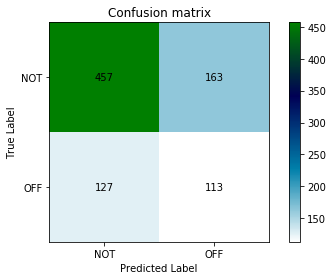

In [0]:
do_analysis(test_data, test_labels, cnn)

In [0]:
cnn1 = Sequential()
cnn1.add(Embedding(vocab_length, 30, input_length=longest_seq))
cnn1.add(Reshape((30,longest_seq,1)))
cnn1.add(Convolution2D(32,(1,5),activation="relu"))
cnn1.add(MaxPooling2D(pool_size=(2,2)))
cnn1.add(Dropout(0.5))
cnn1.add(Convolution2D(16,(2,3),activation="relu"))
cnn1.add(Dropout(0.5))
cnn1.add(MaxPooling2D(pool_size=(2,2)))
cnn1.add(Convolution2D(16,(2,2),activation="relu"))
cnn1.add(Dropout(0.6))
cnn1.add(Flatten())
cnn1.add(Dense(train_labels.shape[1],activation='sigmoid'))
cnn1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
cnn1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 44, 30)            472380    
_________________________________________________________________
reshape_3 (Reshape)          (None, 30, 44, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 40, 32)        192       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 20, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 20, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 18, 16)        3088      
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 18, 16)      

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
cnn1.fit(train_data, train_labels, batch_size=64,epochs=60,verbose=1,validation_data=(val_data,val_labels),callbacks=[early_stopping])

Train on 8606 samples, validate on 4634 samples
Epoch 1/60
8606/8606 [==============================] - 6s 684us/step - loss: 0.6409 - acc: 0.6633 - val_loss: 0.6403 - val_acc: 0.6677
Epoch 2/60
8606/8606 [==============================] - 2s 213us/step - loss: 0.6373 - acc: 0.6677 - val_loss: 0.6438 - val_acc: 0.6677
Epoch 3/60
8606/8606 [==============================] - 2s 213us/step - loss: 0.6315 - acc: 0.6677 - val_loss: 0.6358 - val_acc: 0.6677
Epoch 4/60
8606/8606 [==============================] - 2s 215us/step - loss: 0.5576 - acc: 0.7139 - val_loss: 0.6057 - val_acc: 0.6770
Epoch 5/60
8606/8606 [==============================] - 2s 215us/step - loss: 0.4215 - acc: 0.8023 - val_loss: 0.6179 - val_acc: 0.6927
Epoch 6/60
8606/8606 [==============================] - 2s 214us/step - loss: 0.3070 - acc: 0.8677 - val_loss: 0.6711 - val_acc: 0.6577


In [0]:
cnn1.evaluate(test_data, test_labels, batch_size=64, verbose=1)

860/860 [==============================] - 0s 91us/step


[0.6208050087440845, 0.6941860470660898]

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       620
           1       0.41      0.47      0.44       240

    accuracy                           0.66       860
   macro avg       0.60      0.60      0.60       860
weighted avg       0.68      0.66      0.67       860

[[0.73709677 0.26290323]
 [0.52916667 0.47083333]]


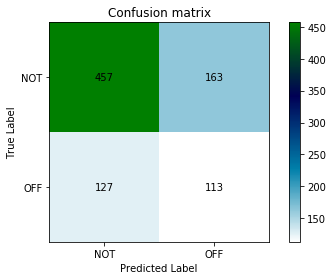

In [0]:
do_analysis(test_data, test_labels, cnn)